In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA GeForce RTX 4070 Ti


In [ ]:
import time, math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# FLOP counting
from fvcore.nn import FlopCountAnalysis


In [4]:
class SimpleSelfAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model, self.h, self.d_k = d_model, num_heads, d_model // num_heads
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        B, T, D = x.shape
        h, d_k = self.h, self.d_k
        q = self.Wq(x).view(B, T, h, d_k).transpose(1, 2)
        k = self.Wk(x).view(B, T, h, d_k).transpose(1, 2)
        v = self.Wv(x).view(B, T, h, d_k).transpose(1, 2)
        att = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        att = torch.softmax(att, dim=-1)
        y = torch.matmul(att, v)
        y = y.transpose(1, 2).contiguous().view(B, T, D)
        return self.Wo(y)


In [ ]:
def profile_once(T, device, d_model=512, num_heads=8, repeats=5):
    B = 1
    model = SimpleSelfAttention(d_model, num_heads).to(device)
    x = torch.randn(B, T, d_model, device=device)

    # FLOPs
    flops = FlopCountAnalysis(model, (x,)).total()

    times, mems = [], []
    for _ in range(repeats):
        if device.type == "cuda":
            torch.cuda.reset_peak_memory_stats()
        t0 = time.perf_counter()
        y = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1e3) 
        if device.type == "cuda":
            mems.append(torch.cuda.max_memory_allocated())
        else:
            mems.append(y.numel() * y.element_size()) 

    mean_time, se_time = np.mean(times), np.std(times)/np.sqrt(len(times))
    mean_mem, se_mem = np.mean(mems), np.std(mems)/np.sqrt(len(mems))
    return {"flops": flops, "time": (mean_time, se_time), "mem": (mean_mem, se_mem)}


In [6]:
seq_lens = [10, 100, 1000, 10000]
devices = [torch.device("cpu")]
if torch.cuda.is_available():
    devices.append(torch.device("cuda"))

results = {}
for dev in devices:
    print(f"\nRunning on {dev}")
    res = {}
    for T in seq_lens:
        try:
            out = profile_once(T, dev)
            res[T] = out
            print(f"T={T:<5d} FLOPs={out['flops']:.2e}, time={out['time'][0]:.2f}ms, mem={out['mem'][0]/1e6:.1f} MB")
        except RuntimeError as e:
            print(f"T={T} failed: {e}")
    results[dev.type] = res


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)



Running on cpu
T=10    FLOPs=1.06e+07, time=0.42ms, mem=0.0 MB
T=100   FLOPs=1.15e+08, time=1.57ms, mem=0.2 MB
T=1000  FLOPs=2.07e+09, time=33.41ms, mem=2.0 MB


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


T=10000 FLOPs=1.13e+11, time=2472.87ms, mem=20.5 MB


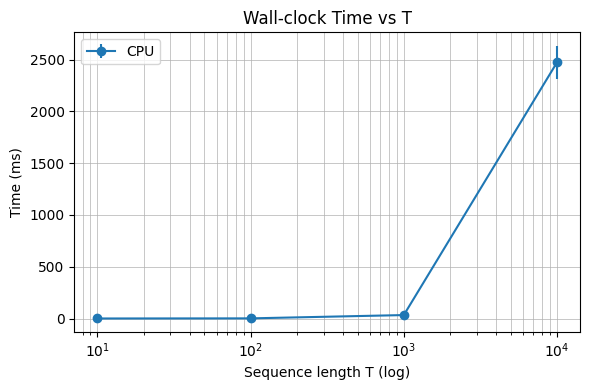

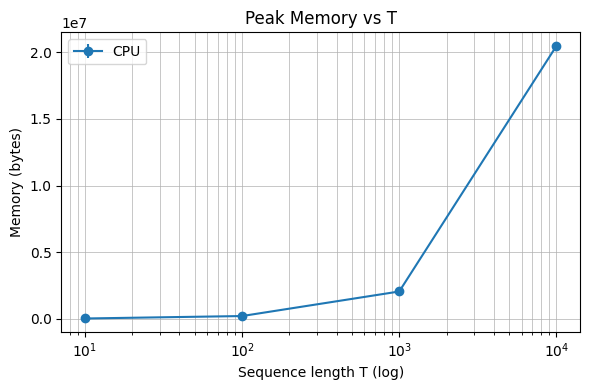

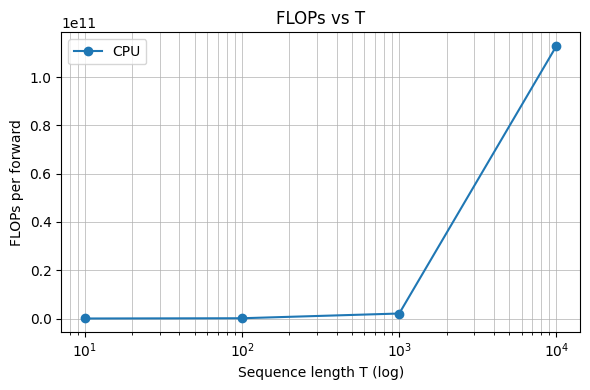

In [ ]:
def plot_metric(results, key, ylabel, title):
    plt.figure(figsize=(6,4))
    for dev_type, res in results.items():
        xs, means, errs = [], [], []
        for T,v in res.items():
            m,e = v[key]
            xs.append(T); means.append(m); errs.append(e)
        plt.errorbar(xs, means, yerr=errs, marker="o", label=dev_type.upper())
    plt.xscale("log")
    plt.xlabel("Sequence length T (log)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which="both", linewidth=0.5)
    plt.legend()
    plt.tight_layout()

plot_metric(results, "time", "Time (ms)", "Wall-clock Time vs T")
plot_metric(results, "mem", "Memory (bytes)", "Peak Memory vs T")

plt.figure(figsize=(6,4))
for dev_type, res in results.items():
    xs, ys = [], []
    for T,v in res.items():
        xs.append(T); ys.append(v["flops"])
    plt.plot(xs, ys, marker="o", label=dev_type.upper())
plt.xscale("log")
plt.xlabel("Sequence length T (log)")
plt.ylabel("FLOPs per forward")
plt.title("FLOPs vs T")
plt.grid(True, which="both", linewidth=0.5)
plt.legend()
plt.tight_layout()
